In [1]:
import pandas as pd
from src.io_utils import load_data, coerce_numeric

df = coerce_numeric(load_data("data/library_loans.csv"))
df = df.dropna(subset=["loan_days"]).copy()
df = df[df["loan_days"] > 0].copy()

df["month"] = df["checkout_date"].dt.to_period("M").dt.to_timestamp()
df["week"] = df["checkout_date"].dt.to_period("W").dt.start_time

df.info()
# df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   loan_id           30 non-null     object        
 1   checkout_date     30 non-null     datetime64[ns]
 2   branch            30 non-null     object        
 3   genre             30 non-null     object        
 4   item_type         30 non-null     object        
 5   patron_age_group  30 non-null     object        
 6   loan_days         30 non-null     int64         
 7   returned_date     30 non-null     datetime64[ns]
 8   overdue_days      30 non-null     int64         
 9   fine_amount       30 non-null     float64       
 10  month             30 non-null     datetime64[ns]
 11  week              30 non-null     datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(2), object(5)
memory usage: 2.9+ KB


In [2]:
from src import metrics as M

print("Totalt antal lån:", M.total_loans(df))
print("Genomsnittlig lånetid (dagar:)", f"{M.avg_loan_days(df):.1f}")
print("Andel övertid (%)", f"{100 * M.overdue_rate(df):.1f}%")

Totalt antal lån: 30
Genomsnittlig lånetid (dagar:) 15.6
Andel övertid (%) 50.0%


In [3]:
by_genre = M.loans_by_genre(df)
by_branch = M.loans_by_branch(df)
by_genre
by_branch

,branch,loans
0,Lund Central,8
1,Stockholm Söder,6
2,Malmö City,6
3,Göteborg Centrum,5
4,Uppsala Stadsbibliotek,5


In [4]:
ts_month = M.loans_over_time(df, freq="M")
ts_month.head()

c:\Users\magda\OneDrive\Desktop\EDA - Bibliotek\src\metrics.py:42: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(freq)["loan_id"]


,checkout_date,loans
0,2025-01-31,3
1,2025-02-28,5
2,2025-03-31,4
3,2025-04-30,2
4,2025-05-31,1


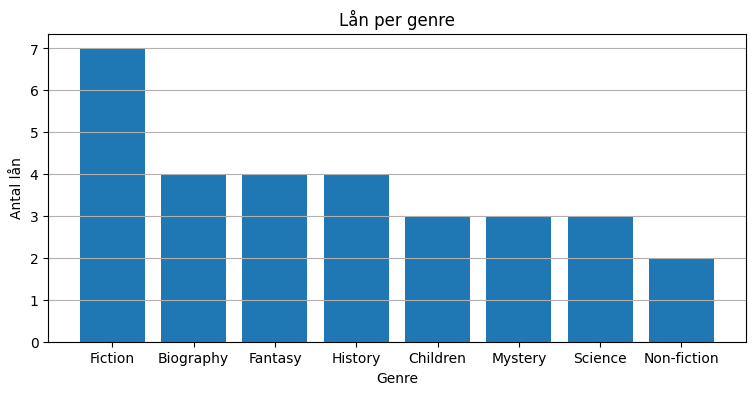

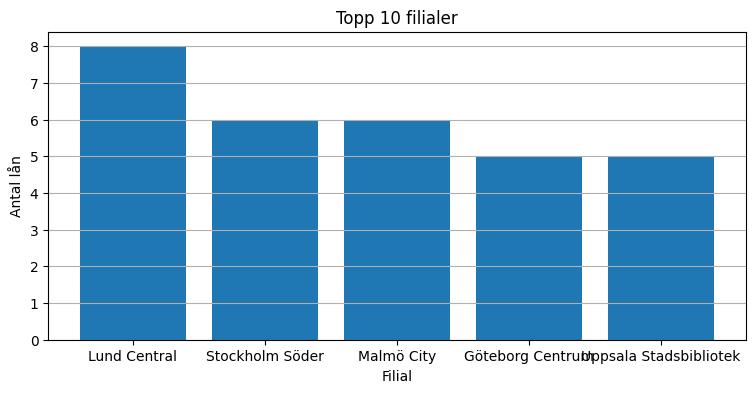

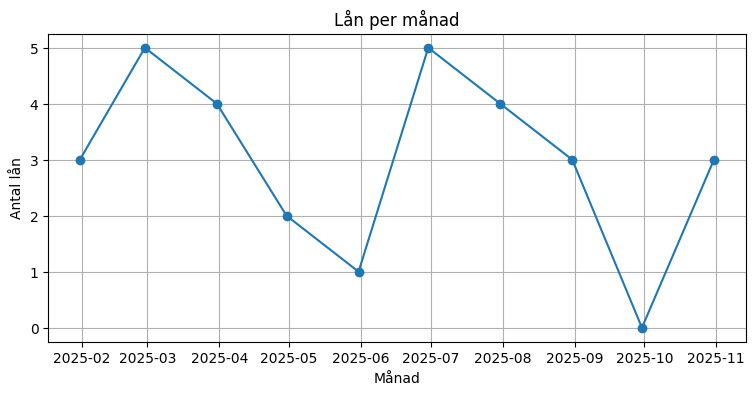

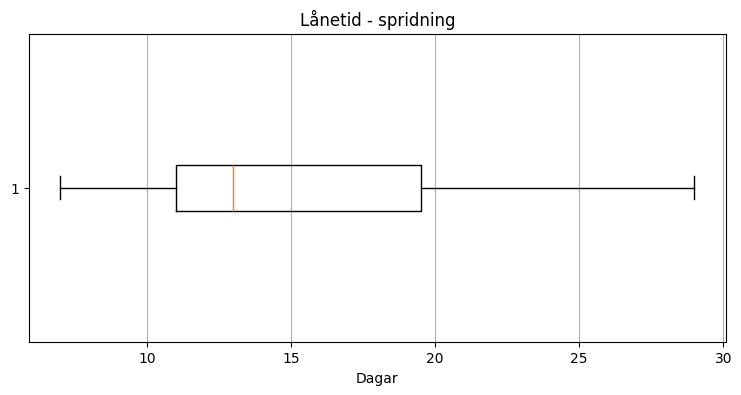

In [8]:
import matplotlib.pyplot as plt
from src import viz as V

# Lån per genre
fig, ax = plt.subplots(figsize=(9, 4))
V.bar(ax, by_genre["genre"], by_genre["loans"], "Lån per genre", "Genre", "Antal lån")
plt.savefig("images/fig_loans_by_genre.png", dpi=200)

# Top-10 filialer
fig, ax = plt.subplots(figsize=(9, 4))
top_10 = by_branch.head(10)
V.bar(ax, top_10["branch"], top_10["loans"], "Topp 10 filialer", "Filial", "Antal lån")
plt.savefig("images/fig_top10_branches.png", dpi=200)

# Lån per månad
fig, ax = plt.subplots(figsize=(9, 4))
V.line(ax, ts_month["checkout_date"], ts_month["loans"], "Lån per månad", "Månad", "Antal lån")
plt.savefig("images/fig_loans_over_months.png", dpi=200)

# Spridning av lånetid
fig, ax = plt.subplots(figsize=(9, 4))
V.box_h(ax, df["loan_days"], "Lånetid - spridning", "Dagar")
plt.savefig("images/fig_loan_days_box.png", dpi=200)

In [9]:
piv = pd.pivot_table(
    df,
    index="branch",
    columns="genre",
    values="loan_id",
    aggfunc="nunique",
    fill_value=0,
    margins=True
)

piv.to_csv("data/pivot_branch_x_genre.csv")
piv.head()

genre,Biography,Children,Fantasy,Fiction,History,Mystery,Non-fiction,Science,All
branch,,,,,,,,,
Göteborg Centrum,1,1,1,1,0,1,0,0,5
Lund Central,0,2,1,1,2,1,0,1,8
Malmö City,2,0,0,4,0,0,0,0,6
Stockholm Söder,1,0,2,1,1,1,0,0,6
Uppsala Stadsbibliotek,0,0,0,0,1,0,2,2,5


In [7]:
M.top3_genres(df), M.top3_branches(df)

(       genre  loans
 0    Fiction      7
 1  Biography      4
 2    Fantasy      4,
             branch  loans
 0     Lund Central      8
 1  Stockholm Söder      6
 2       Malmö City      6)

## Rekommendationer:
- Stärk inköp i Fiction - Högst efterfrågan
- Bemanna extra i Lund Central under månader med toppar.
- Följ upp övertidsandelen (nu 50%): förbättra påminnelser.